# Chapter 5.2

## Importing Libraries

In [1]:
from __future__ import absolute_import, division, print_function
from __future__ import unicode_literals

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy
import tqdm
from hfunc import models
from hfunc import metrics
import time

## Self-created functions

In [3]:
def node_pruning(model, tester_model, x, y, layer_sizes, tol, ignore_cutoff, method='exhaustive'):

    loss, acc = model.evaluate(x, y, verbose=0, batch_size=256)
    original = model.get_weights()
    weight_len = len(original) - 3
    bas = [acc]
    bls = [loss]
    best_weights = model.get_weights()
    best_acc = 0
    best_loss = 1e20
    ol = loss
    oa = acc
    amounts = []
    places = []

    for layer, size in enumerate(layer_sizes):
        end_not_reached = True
        num_removed = 0
        nodes_removed = []
        if method == 'exhaustive':
            current_pos = 0
            best_change = tol
            best_pos = -1
            improved = False
            while end_not_reached or improved:
                if not(end_not_reached):
                    end_not_reached = True
                    improved = False
                    current_pos = 0
                    size -= 1
                    nodes_removed += [best_pos]
                    best_weights[weight_len - (2*layer+1)][...,best_pos] = 0
                    best_weights[weight_len - 2*layer][best_pos] = 0
                    best_pos = -1
                    ol = best_loss
                    oa = best_acc
                    bas += [best_acc]
                    bls += [best_loss]
                    best_change = tol
                    num_removed += 1
                if current_pos in nodes_removed:
                    current_pos += 1
                    if current_pos - num_removed >= size:
                        end_not_reached = False
                    continue
                w = copy.deepcopy(best_weights)
                w[weight_len - (2*layer+1)][...,current_pos] = 0
                w[weight_len - 2*layer][current_pos] = 0
                tester_model.set_weights(w)
                nl, na = tester_model.evaluate(x, y, verbose=0, batch_size=256)
                if ol - nl >= best_change:
                    best_change = ol - nl
                    best_pos = current_pos
                    improved = True
                    best_acc = na
                    best_loss = nl
                current_pos += 1
                if current_pos - num_removed >= size:
                    end_not_reached = False
        elif method == 'greedy':
            nodes_to_estimate = list(np.arange(size))
            current_pos = nodes_to_estimate[0]
            idx = 0
            while end_not_reached:
                w = copy.deepcopy(best_weights)
                w[weight_len - (2*layer+1)][...,current_pos] = 0
                w[weight_len - 2*layer][current_pos] = 0
                tester_model.set_weights(w)
                nl, na = tester_model.evaluate(x, y, verbose=0, batch_size=256)
                if ol - nl >= tol:
                    oa = na
                    ol = nl
                    size -= 1
                    nodes_removed += [current_pos]
                    nodes_to_estimate.remove(current_pos)
                    best_weights[weight_len - (2*layer+1)][..., current_pos] = 0
                    best_weights[weight_len - 2*layer][current_pos] = 0
                    bas += [oa]
                    bls += [ol]
                    num_removed += 1
                    idx = 0
                elif ol - nl <= ignore_cutoff:
                    size -= 1
                    nodes_to_estimate.remove(current_pos)
                else:
                    idx += 1
                if idx >= size:
                    end_not_reached = False
                else:
                    current_pos = nodes_to_estimate[idx]
        amounts.append(num_removed)
        places.append(nodes_removed)

    return best_weights, bas, bls, amounts, places

## Convolutional Neural Network

### MNIST

In [4]:
np.random.seed(2020)

In [5]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [7]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
trials = 10
tol = -1e-5
ig_cutoff = -1e-3
layer_sizes = [64, 256, 128, 64, 32]
old_class_accs = np.zeros((trials, 10))
new_class_accs = np.zeros((trials, 10))
diff_class_accs = np.zeros((trials, 10))
old_accs = np.zeros((trials))
new_accs = np.zeros((trials))
old_losses = np.zeros((trials))
new_losses = np.zeros((trials))
for trial in tqdm.trange(trials):
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
        ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, verbose=0, epochs=5)
    old_losses[trial], old_accs[trial] = model.evaluate(x_test, y_test, verbose=0)
    
    y_pred = model.predict(x_test)
    K = 10
    acc1 = []
    yp = np.argmax(y_pred, axis=1)
    for i in range(K):
        a = np.mean((yp[y_test == i] == y_test[y_test == i]))
        acc1.append(a)
    old_class_accs[trial] = acc1
    
    
    shrinked_weights, acc_ev, loss_ev, num_rem, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol, ig_cutoff, method='greedy')
    
    tester_model.set_weights(shrinked_weights)
    new_losses[trial], new_accs[trial] = tester_model.evaluate(x_test, y_test, verbose=0)
    
    y_pred = tester_model.predict(x_test)
    K = 10
    acc2 = []
    yp = np.argmax(y_pred, axis=1)
    for i in range(K):
        a = np.mean((yp[y_test == i] == y_test[y_test == i]))
        acc2.append(a)
    new_class_accs[trial] = acc2
    
    diff_class_accs[trial] = np.array(acc2) - np.array(acc1)

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [2:14:08<00:00, 804.84s/it]


In [9]:
DCA = pd.DataFrame(diff_class_accs)
DCA.to_csv('../../../results/diff_class_acc_CNN_class_mnist.csv')
DCA.describe()

,0,1,2,3,4,5,6,7,8,9
count,10.000000,1.000000e+01,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.003163,-2.220446e-17,0.001163,0.004455,0.000102,-0.001457,0.004906,0.002140,0.005031,0.003568
std,0.006690,2.076672e-03,0.004979,0.006196,0.006711,0.006187,0.013422,0.004248,0.009353,0.006324
min,-0.003061,-2.643172e-03,-0.003876,0.000000,-0.009165,-0.010090,-0.005219,-0.003891,-0.005133,-0.005946
25%,-0.000765,-8.810573e-04,-0.002665,0.000248,-0.004582,-0.005605,-0.002088,-0.001459,-0.001027,0.000248
50%,0.002041,-4.405286e-04,-0.000484,0.003465,0.000509,-0.001682,0.000522,0.001946,0.001027,0.001487
75%,0.003827,0.000000e+00,0.003391,0.005446,0.004073,0.000000,0.004175,0.004864,0.013860,0.006194
max,0.020408,4.405286e-03,0.011628,0.020792,0.009165,0.011211,0.039666,0.009728,0.018480,0.016848


In [10]:
OCA = pd.DataFrame(old_class_accs)
OCA.to_csv('../../../results/old_class_acc_CNN_class_mnist.csv')
OCA.describe()

,0,1,2,3,4,5,6,7,8,9
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.992041,0.996300,0.990698,0.991881,0.989613,0.991816,0.984864,0.988424,0.987474,0.982953
std,0.007371,0.002110,0.006732,0.005713,0.008073,0.007052,0.014524,0.003536,0.010885,0.006521
min,0.973469,0.992070,0.975775,0.976238,0.972505,0.978700,0.949896,0.981518,0.970226,0.972250
25%,0.991837,0.995595,0.988372,0.991584,0.987016,0.993274,0.987213,0.987597,0.980236,0.979683
50%,0.992857,0.996916,0.992733,0.994059,0.989817,0.994395,0.991649,0.989300,0.991786,0.984143
75%,0.996684,0.997357,0.995155,0.994059,0.996690,0.995516,0.992693,0.990759,0.994610,0.987116
max,0.998980,0.999119,0.998062,0.996040,0.997963,0.997758,0.993737,0.992218,1.000000,0.991080


In [11]:
NCA = pd.DataFrame(new_class_accs)
NCA.to_csv('../../../results/new_class_acc_CNN_class_mnist.csv')
NCA.describe()

,0,1,2,3,4,5,6,7,8,9
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.995204,0.996300,0.991860,0.996337,0.989715,0.990359,0.989770,0.990564,0.992505,0.986521
std,0.002099,0.001232,0.002468,0.001239,0.003913,0.003631,0.003366,0.002340,0.003591,0.002925
min,0.991837,0.994714,0.987403,0.994059,0.981670,0.983184,0.982255,0.988327,0.986653,0.982161
25%,0.993878,0.995154,0.990310,0.995297,0.988035,0.988229,0.987996,0.988570,0.990760,0.985134
50%,0.994388,0.996476,0.991764,0.997030,0.989817,0.990471,0.990605,0.989786,0.992300,0.986620
75%,0.996939,0.997137,0.993702,0.997030,0.991599,0.992713,0.991649,0.991975,0.994610,0.988850
max,0.997959,0.998238,0.995155,0.998020,0.996945,0.995516,0.993737,0.995136,0.998973,0.990089


In [12]:
A = pd.DataFrame(np.array([old_accs, new_accs]).T, columns=['Before Pruning', 'After Pruning'])
A.to_csv('../../../results/acc_CNN_class_mnist.csv')
A.describe()

,Before Pruning,After Pruning
count,10.000000,10.000000
mean,0.989690,0.991990
std,0.002035,0.000597
min,0.986900,0.991100
25%,0.987900,0.991400
50%,0.990250,0.992200
75%,0.991425,0.992475
max,0.992000,0.992600


In [13]:
L = pd.DataFrame(np.array([old_losses, new_losses]).T, columns=['Before Pruning', 'After Pruning'])
L.to_csv('../../../results/loss_CNN_class_mnist.csv')
L.describe()

,Before Pruning,After Pruning
count,10.000000,10.000000
mean,0.037713,0.030169
std,0.008542,0.001988
min,0.026948,0.027514
25%,0.031618,0.028351
50%,0.034824,0.030231
75%,0.043013,0.031617
max,0.051010,0.033209


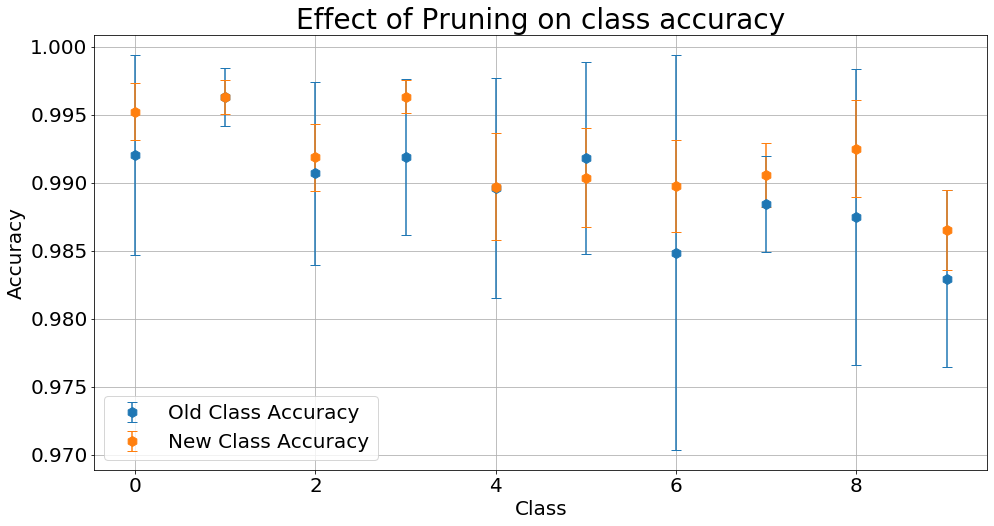

In [14]:
plt.rcParams["figure.figsize"] = (16,8)
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = OCA.mean().to_numpy()
std_1 = OCA.std().to_numpy()
m_2 = NCA.mean().to_numpy()
std_2 = NCA.std().to_numpy()
plt.errorbar(x=np.arange(10), y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Old Class Accuracy', fmt='o')
plt.errorbar(x=np.arange(10), y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='New Class Accuracy', fmt='o')
plt.legend(fontsize=20)
plt.title("Effect of Pruning on class accuracy", size=28)
plt.xlabel("Class", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/acc_eff_CNN_class_mnist.png")

### Fashion MNIST

In [15]:
np.random.seed(2020)

In [16]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fmnist.load_data()
x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [17]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [18]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
trials = 10
tol = -1e-5
ig_cutoff = -1e-3
layer_sizes = [64, 256, 128, 64, 32]
old_class_accs = np.zeros((trials, 10))
new_class_accs = np.zeros((trials, 10))
diff_class_accs = np.zeros((trials, 10))
old_accs = np.zeros((trials))
new_accs = np.zeros((trials))
old_losses = np.zeros((trials))
new_losses = np.zeros((trials))
for trial in tqdm.trange(trials):
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
        ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, verbose=0, epochs=5)
    old_losses[trial], old_accs[trial] = model.evaluate(x_test, y_test, verbose=0)
    
    y_pred = model.predict(x_test)
    K = 10
    acc1 = []
    yp = np.argmax(y_pred, axis=1)
    for i in range(K):
        a = np.mean((yp[y_test == i] == y_test[y_test == i]))
        acc1.append(a)
    old_class_accs[trial] = acc1
    
    
    shrinked_weights, acc_ev, loss_ev, num_rem, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol, ig_cutoff, method='greedy')
    
    tester_model.set_weights(shrinked_weights)
    new_losses[trial], new_accs[trial] = tester_model.evaluate(x_test, y_test, verbose=0)
    
    y_pred = tester_model.predict(x_test)
    K = 10
    acc2 = []
    yp = np.argmax(y_pred, axis=1)
    for i in range(K):
        a = np.mean((yp[y_test == i] == y_test[y_test == i]))
        acc2.append(a)
    new_class_accs[trial] = acc2
    
    diff_class_accs[trial] = np.array(acc2) - np.array(acc1)

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [2:09:19<00:00, 775.98s/it]


In [21]:
DCA = pd.DataFrame(diff_class_accs)
DCA.to_csv('../../../results/diff_class_acc_CNN_class_fmnist.csv')
DCA.describe()

,0,1,2,3,4,5,6,7,8,9
count,10.00000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.02550,-0.002200,0.01170,0.006600,-0.004900,0.000600,-0.017600,0.008200,-0.004400,-0.006200
std,0.03987,0.003765,0.03937,0.018518,0.028396,0.008682,0.064117,0.011942,0.004551,0.011013
min,-0.04100,-0.007000,-0.06300,-0.016000,-0.027000,-0.011000,-0.090000,-0.012000,-0.013000,-0.022000
25%,0.00400,-0.005750,-0.01500,-0.008250,-0.022250,-0.005500,-0.073250,0.005250,-0.006750,-0.015000
50%,0.03200,-0.002000,0.02050,0.003000,-0.014000,-0.001000,-0.025500,0.008500,-0.004500,-0.006500
75%,0.05275,0.000000,0.03825,0.022750,0.000750,0.006750,0.010750,0.013250,-0.001000,0.003000
max,0.07600,0.004000,0.06700,0.034000,0.068000,0.016000,0.100000,0.032000,0.002000,0.009000


In [22]:
OCA = pd.DataFrame(old_class_accs)
OCA.to_csv('../../../results/old_class_acc_CNN_class_fmnist.csv')
OCA.describe()

,0,1,2,3,4,5,6,7,8,9
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.852500,0.985600,0.856600,0.921300,0.869100,0.979400,0.732500,0.969500,0.988200,0.963300
std,0.037116,0.001897,0.036752,0.022731,0.027739,0.012834,0.069096,0.013567,0.003011,0.010563
min,0.815000,0.983000,0.800000,0.880000,0.804000,0.951000,0.608000,0.942000,0.984000,0.949000
25%,0.828000,0.984250,0.829250,0.911250,0.860750,0.975500,0.700500,0.964000,0.986500,0.955500
50%,0.838500,0.985000,0.851000,0.926500,0.871000,0.982500,0.765500,0.967000,0.988000,0.963500
75%,0.874250,0.986750,0.887750,0.938000,0.886500,0.987500,0.785250,0.978750,0.988750,0.972750
max,0.920000,0.989000,0.908000,0.950000,0.901000,0.994000,0.794000,0.990000,0.994000,0.978000


In [23]:
NCA = pd.DataFrame(new_class_accs)
NCA.to_csv('../../../results/new_class_acc_CNN_class_fmnist.csv')
NCA.describe()

,0,1,2,3,4,5,6,7,8,9
count,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.00000,10.00000
mean,0.878000,0.983400,0.868300,0.92790,0.864200,0.980000,0.714900,0.977700,0.98380,0.95710
std,0.012961,0.003273,0.011851,0.00802,0.016206,0.006976,0.020426,0.004692,0.00391,0.00584
min,0.856000,0.978000,0.845000,0.91100,0.842000,0.967000,0.693000,0.970000,0.97500,0.94400
25%,0.867500,0.982000,0.862250,0.92350,0.852250,0.977500,0.701000,0.974500,0.98225,0.95550
50%,0.878500,0.983500,0.869500,0.92850,0.864000,0.981500,0.708500,0.978000,0.98450,0.95700
75%,0.888250,0.985750,0.876000,0.93325,0.871250,0.985500,0.731500,0.978750,0.98600,0.95900
max,0.893000,0.988000,0.884000,0.93800,0.898000,0.987000,0.751000,0.985000,0.98900,0.96600


In [24]:
A = pd.DataFrame(np.array([old_accs, new_accs]).T, columns=['Before Pruning', 'After Pruning'])
A.to_csv('../../../results/acc_CNN_class_fmnist.csv')
A.describe()

,Before Pruning,After Pruning
count,10.000000,10.000000
mean,0.911800,0.913530
std,0.002728,0.001525
min,0.907200,0.911000
25%,0.909800,0.913250
50%,0.911600,0.913700
75%,0.913975,0.914150
max,0.916100,0.916100


In [25]:
L = pd.DataFrame(np.array([old_losses, new_losses]).T, columns=['Before Pruning', 'After Pruning'])
L.to_csv('../../../results/loss_CNN_class_fmnist.csv')
L.describe()

,Before Pruning,After Pruning
count,10.000000,10.000000
mean,0.250866,0.237752
std,0.013486,0.005096
min,0.233986,0.229344
25%,0.243321,0.234261
50%,0.250524,0.237853
75%,0.252903,0.239829
max,0.280851,0.245588


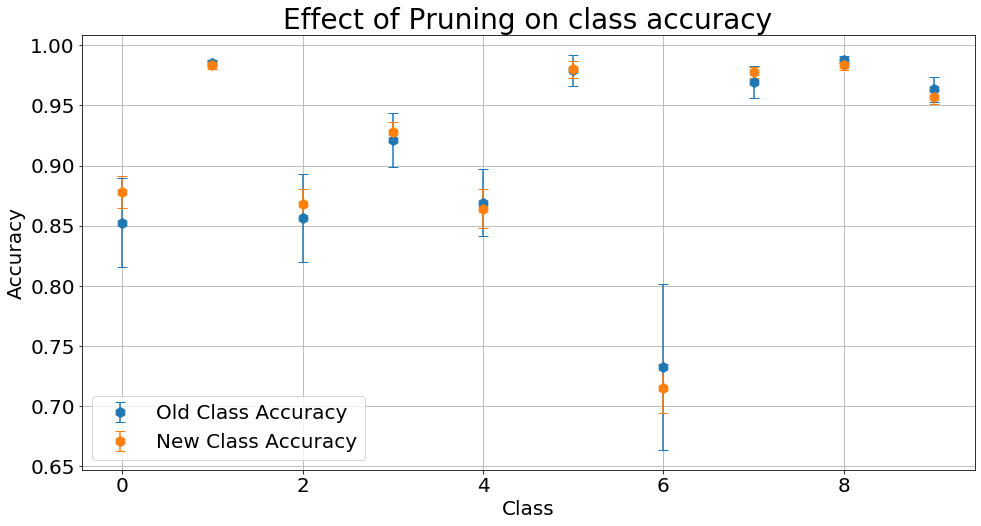

In [26]:
plt.rcParams["figure.figsize"] = (16,8)
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = OCA.mean().to_numpy()
std_1 = OCA.std().to_numpy()
m_2 = NCA.mean().to_numpy()
std_2 = NCA.std().to_numpy()
plt.errorbar(x=np.arange(10), y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Old Class Accuracy', fmt='o')
plt.errorbar(x=np.arange(10), y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='New Class Accuracy', fmt='o')
plt.legend(fontsize=20)
plt.title("Effect of Pruning on class accuracy", size=28)
plt.xlabel("Class", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/acc_eff_CNN_class_fmnist.png")

### CIFAR 10

In [32]:
np.random.seed(2020)

In [33]:
cifar = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [34]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [35]:
trials = 10
tol = -1e-5
ig_cutoff = -1e-3
layer_sizes = [64, 256, 128, 64, 32]
old_class_accs = np.zeros((trials, 10))
new_class_accs = np.zeros((trials, 10))
diff_class_accs = np.zeros((trials, 10))
old_accs = np.zeros((trials))
new_accs = np.zeros((trials))
old_losses = np.zeros((trials))
new_losses = np.zeros((trials))
for trial in tqdm.trange(trials):
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
        ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, verbose=0, epochs=5)
    old_losses[trial], old_accs[trial] = model.evaluate(x_test, y_test, verbose=0)
    
    y_pred = model.predict(x_test)
    K = 10
    acc1 = []
    yp = np.argmax(y_pred, axis=1)
    for i in range(K):
        a = np.mean((yp[y_test.reshape(-1) == i] == y_test[y_test == i]))
        acc1.append(a)
    old_class_accs[trial] = acc1
    
    
    shrinked_weights, acc_ev, loss_ev, num_rem, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol, ig_cutoff, method='greedy')
    
    tester_model.set_weights(shrinked_weights)
    new_losses[trial], new_accs[trial] = tester_model.evaluate(x_test, y_test, verbose=0)
    
    y_pred = tester_model.predict(x_test)
    K = 10
    acc2 = []
    yp = np.argmax(y_pred, axis=1)
    for i in range(K):
        a = np.mean((yp[y_test.reshape(-1) == i] == y_test[y_test == i]))
        acc2.append(a)
    new_class_accs[trial] = acc2
    
    diff_class_accs[trial] = np.array(acc2) - np.array(acc1)

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [1:17:44<00:00, 466.41s/it]


In [36]:
diff_class_accs

array([[ 0.007,  0.024, -0.039, -0.055,  0.091, -0.021,  0.084,  0.053,
        -0.015, -0.089],
       [-0.056,  0.036, -0.026,  0.016, -0.01 ,  0.001,  0.028, -0.017,
         0.065, -0.039],
       [ 0.085,  0.015, -0.23 ,  0.057,  0.069,  0.08 , -0.044, -0.015,
         0.   , -0.002],
       [-0.046, -0.037, -0.004,  0.153, -0.006, -0.096, -0.035,  0.005,
        -0.013,  0.068],
       [-0.015, -0.03 , -0.039,  0.093,  0.035,  0.031,  0.009, -0.07 ,
        -0.007, -0.029],
       [ 0.044,  0.015, -0.049,  0.055, -0.053, -0.044, -0.006,  0.015,
         0.021, -0.003],
       [ 0.   , -0.031, -0.079, -0.016, -0.01 , -0.008,  0.043,  0.048,
         0.022,  0.006],
       [-0.019,  0.039,  0.052,  0.035, -0.045, -0.005, -0.071, -0.005,
         0.064, -0.025],
       [-0.099, -0.012, -0.056, -0.031,  0.103,  0.02 ,  0.029,  0.018,
         0.024,  0.   ],
       [-0.051,  0.049, -0.017, -0.046,  0.013,  0.131,  0.07 , -0.028,
        -0.042, -0.036]])

In [37]:
DCA = pd.DataFrame(diff_class_accs)
DCA.to_csv('../../../results/diff_class_acc_CNN_class_cifar.csv')
DCA.describe()

,0,1,2,3,4,5,6,7,8,9
count,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000
mean,-0.015000,0.006800,-0.048700,0.02610,0.018700,0.008900,0.010700,0.000400,0.01190,-0.014900
std,0.052915,0.031895,0.072792,0.06613,0.054384,0.063081,0.050116,0.036375,0.03434,0.040355
min,-0.099000,-0.037000,-0.230000,-0.05500,-0.053000,-0.096000,-0.071000,-0.070000,-0.04200,-0.089000
25%,-0.049750,-0.025500,-0.054250,-0.02725,-0.010000,-0.017750,-0.027750,-0.016500,-0.01150,-0.034250
50%,-0.017000,0.015000,-0.039000,0.02550,0.003500,-0.002000,0.018500,0.000000,0.01050,-0.014000
75%,0.005250,0.033000,-0.019250,0.05650,0.060500,0.028250,0.039500,0.017250,0.02350,-0.000500
max,0.085000,0.049000,0.052000,0.15300,0.103000,0.131000,0.084000,0.053000,0.06500,0.068000


In [38]:
OCA = pd.DataFrame(old_class_accs)
OCA.to_csv('../../../results/old_class_acc_CNN_class_cifar.csv')
OCA.describe()

,0,1,2,3,4,5,6,7,8,9
count,10.000000,10.000000,10.000000,10.00000,10.000000,10.00000,10.00000,10.00000,10.000000,10.000000
mean,0.786900,0.848600,0.639400,0.50000,0.688900,0.63360,0.80920,0.77350,0.824200,0.819000
std,0.050318,0.030493,0.059653,0.07786,0.062527,0.08483,0.05097,0.04138,0.037431,0.045833
min,0.710000,0.791000,0.549000,0.36400,0.567000,0.43400,0.72100,0.71600,0.751000,0.715000
25%,0.751000,0.832250,0.613250,0.46550,0.653250,0.59750,0.77875,0.74425,0.814750,0.806250
50%,0.790500,0.848500,0.643000,0.49500,0.705000,0.66550,0.80000,0.76600,0.834000,0.821500
75%,0.808000,0.871500,0.677250,0.54900,0.723750,0.68000,0.85300,0.80075,0.846000,0.835000
max,0.869000,0.894000,0.743000,0.61000,0.792000,0.73300,0.87800,0.84500,0.864000,0.887000


In [39]:
NCA = pd.DataFrame(new_class_accs)
NCA.to_csv('../../../results/new_class_acc_CNN_class_cifar.csv')
NCA.describe()

,0,1,2,3,4,5,6,7,8,9
count,10.000000,10.00000,10.00000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.771900,0.85540,0.59070,0.526100,0.70760,0.642500,0.819900,0.773900,0.836100,0.804100
std,0.019632,0.01853,0.03883,0.018175,0.02004,0.035293,0.019807,0.019952,0.010847,0.013609
min,0.738000,0.83000,0.51300,0.499000,0.67000,0.565000,0.787000,0.749000,0.815000,0.783000
25%,0.766250,0.83825,0.57050,0.515500,0.69750,0.625000,0.805500,0.755750,0.832000,0.797250
50%,0.771500,0.86050,0.59450,0.522500,0.71350,0.653000,0.821500,0.773000,0.838500,0.803000
75%,0.785750,0.86600,0.61650,0.535750,0.71925,0.660750,0.837250,0.787750,0.844000,0.812750
max,0.799000,0.88100,0.64500,0.564000,0.73900,0.691000,0.845000,0.807000,0.850000,0.828000


In [40]:
A = pd.DataFrame(np.array([old_accs, new_accs]).T, columns=['Before Pruning', 'After Pruning'])
A.to_csv('../../../results/acc_CNN_class_cifar.csv')
A.describe()

,Before Pruning,After Pruning
count,10.000000,10.000000
mean,0.732330,0.732820
std,0.006408,0.005790
min,0.725000,0.725600
25%,0.727350,0.727875
50%,0.731350,0.732650
75%,0.734375,0.736300
max,0.745500,0.743000


In [41]:
L = pd.DataFrame(np.array([old_losses, new_losses]).T, columns=['Before Pruning', 'After Pruning'])
L.to_csv('../../../results/loss_CNN_class_cifar.csv')
L.describe()

,Before Pruning,After Pruning
count,10.000000,10.000000
mean,0.801143,0.774570
std,0.023766,0.019195
min,0.759824,0.737917
25%,0.795262,0.764480
50%,0.807635,0.783490
75%,0.815857,0.785484
max,0.830011,0.794645


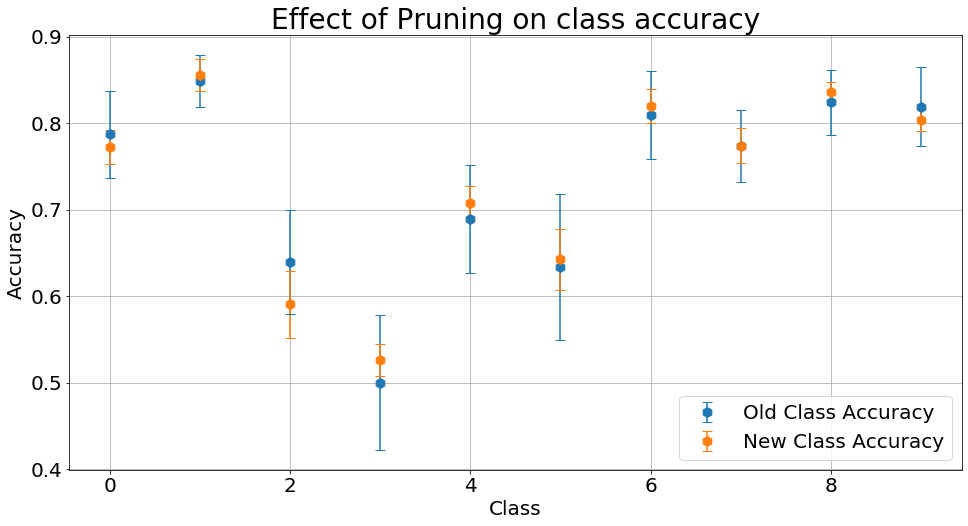

In [42]:
plt.rcParams["figure.figsize"] = (16,8)
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = OCA.mean().to_numpy()
std_1 = OCA.std().to_numpy()
m_2 = NCA.mean().to_numpy()
std_2 = NCA.std().to_numpy()
plt.errorbar(x=np.arange(10), y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Old Class Accuracy', fmt='o')
plt.errorbar(x=np.arange(10), y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='New Class Accuracy', fmt='o')
plt.legend(fontsize=20)
plt.title("Effect of Pruning on class accuracy", size=28)
plt.xlabel("Class", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/acc_eff_CNN_class_cifar.png")